In [3]:
import pandas as pd
import numpy as np

df = pd.read_csv("query-2.csv")
df["time"] = pd.to_datetime(df["time"], errors="coerce")
df = df.dropna(subset=["mag","depth","latitude","longitude"])

print("Total earthquakes:", len(df))


Total earthquakes: 18269


In [4]:
print("Mean magnitude:", df["mag"].mean())
print("Max magnitude:", df["mag"].max())
print("Min magnitude:", df["mag"].min())


Mean magnitude: 4.51229280011224
Max magnitude: 8.8
Min magnitude: 4.0


In [5]:
strongest = df.loc[df["mag"].idxmax()]
print(strongest[["time","place","mag","depth"]])


time                2025-07-29 23:24:52.483000+00:00
place    2025 Kamchatka Peninsula, Russia Earthquake
mag                                              8.8
depth                                           35.0
Name: 8884, dtype: object


In [6]:
print("Mean depth:", df["depth"].mean())
print("Max depth:", df["depth"].max())


Mean depth: 72.45993783927706
Max depth: 669.556


In [7]:
pct_shallow = (df["depth"] < 70).mean() * 100
print("Shallow earthquakes (%):", pct_shallow)


Shallow earthquakes (%): 74.78241830423121


In [8]:
pct_shallow = (df["depth"] < 70).mean() * 100
print("Shallow earthquakes (%):", pct_shallow)


Shallow earthquakes (%): 74.78241830423121


In [2]:
print(df["magType"].value_counts())


magType
mb    2
ml    2
mw    2
Name: count, dtype: int64


In [16]:
df["country"] = df["place"].str.split(",").str[-1].str.strip()
print(df["country"].value_counts().head(5))


country
Russia              4074
Indonesia           1417
Japan               1072
Papua New Guinea     865
Philippines          798
Name: count, dtype: int64


In [17]:
df["date"] = df["time"].dt.date
daily = df.groupby("date").size()

print("Mean per day:", daily.mean())
print("Max in one day:", daily.max())


Mean per day: 50.05205479452055
Max in one day: 645


In [18]:
print("Correlation depth-mag:", df["depth"].corr(df["mag"]))


Correlation depth-mag: -0.13355850349208856


In [13]:
print("Mag ≥ 4.5:", (df["mag"] >= 4.5).sum())


Mag ≥ 4.5: 8556


In [14]:
print("Mean latitude:", df["latitude"].mean())
print("Mean longitude:", df["longitude"].mean())


Mean latitude: 13.618118263528634
Mean longitude: 63.88242618115881


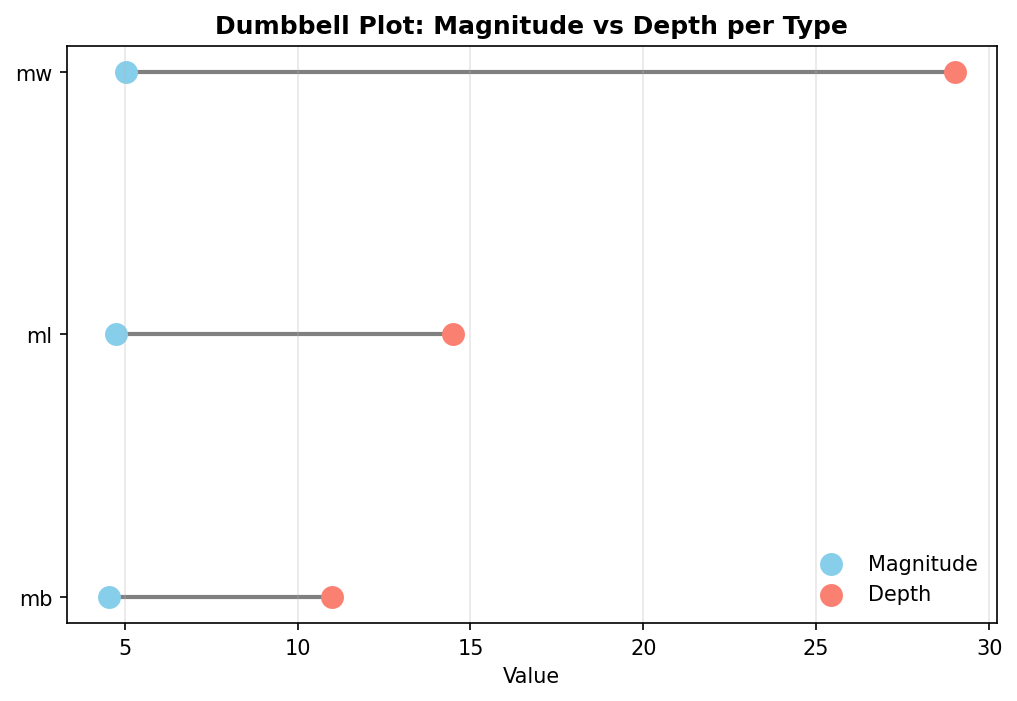

In [1]:
import matplotlib.pyplot as plt

import pandas as pd

def dumbbell_magnitude_depth(df):
    # Calculate averages
    avg_mag = df.groupby("magType")["mag"].mean()
    avg_depth = df.groupby("magType")["depth"].mean()

    types = avg_mag.index.tolist()
    mag_values = avg_mag.values
    depth_values = avg_depth.values

    fig, ax = plt.subplots(figsize=(8, 5), dpi=150)

    # Draw lines between magnitude and depth
    for i, (mag, depth) in enumerate(zip(mag_values, depth_values)):
        ax.plot([mag, depth], [i, i], color='gray', linewidth=2, zorder=1)
        ax.scatter(mag, i, color='skyblue', s=100, label='Magnitude' if i==0 else "")
        ax.scatter(depth, i, color='salmon', s=100, label='Depth' if i==0 else "")

    ax.set_yticks(range(len(types)))
    ax.set_yticklabels(types, fontsize=10)
    ax.set_xlabel("Value")
    ax.set_title("Dumbbell Plot: Magnitude vs Depth per Type", fontsize=12, weight='bold')
    ax.legend(frameon=False)
    plt.grid(axis='x', alpha=0.3)
    plt.show()


# Example usage
df = pd.DataFrame({
    "magType": ["mb", "ml", "mw", "mb", "ml", "mw"],
    "mag": [4.5, 4.7, 5.0, 4.6, 4.8, 5.1],
    "depth": [10, 15, 30, 12, 14, 28]  # in km
})

dumbbell_magnitude_depth(df)

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Base
d = df.copy()
d["time"] = pd.to_datetime(d["time"], utc=True, errors="coerce")
d = d.dropna(subset=["latitude","longitude","depth","mag"]).reset_index(drop=True)

# Simple point sizing
d["s"] = np.clip((d["mag"] - d["mag"].min() + 0.3) * 18, 8, 180)

def haversine_km(lat1, lon1, lat2, lon2):
    R = 6371.0
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat/2)**2 + np.cos(lat1)*np.cos(lat2)*np.sin(dlon/2)**2
    return 2*R*np.arcsin(np.sqrt(a))

# Approx continent boxes + an "anchor" point (lat0, lon0) per continent
continents = {
    "North America": {"lat": (5, 83),   "lon": (-170, -50), "A": (45.0, -120.0)},
    "South America": {"lat": (-60, 15), "lon": (-90, -30),  "A": (-20.0, -70.0)},
    "Europe":        {"lat": (35, 72),  "lon": (-25, 45),   "A": (50.0, 10.0)},
    "Africa":        {"lat": (-35, 38), "lon": (-20, 55),   "A": (0.0, 20.0)},
    "Asia-Oceania":  {"lat": (-50, 80), "lon": (45, 180),   "A": (25.0, 120.0)},
}

# Shared color scale for magnitude
vmin, vmax = float(d["mag"].min()), float(d["mag"].max())

fig, axes = plt.subplots(2, 3, figsize=(15, 8))
axes = axes.ravel()

for i, (name, box) in enumerate(continents.items()):
    ax = axes[i]

    sub = d[
        d["latitude"].between(*box["lat"]) &
        d["longitude"].between(*box["lon"])
    ].copy()

    lat0, lon0 = box["A"]
    sub["dist_km"] = haversine_km(lat0, lon0, sub["latitude"].values, sub["longitude"].values)

    sc = ax.scatter(
        sub["dist_km"], sub["depth"],
        s=sub["s"], c=sub["mag"],
        vmin=vmin, vmax=vmax,
        alpha=0.65
    )

    ax.invert_yaxis()
    ax.set_title(f"{name} (n={len(sub)})")
    ax.set_xlabel("Distance from anchor (km)")
    ax.set_ylabel("Depth (km)")
    ax.grid(alpha=0.25)

# hide the 6th subplot
axes[5].axis("off")

# one colorbar for magnitude
cbar = fig.colorbar(sc, ax=axes[:5], shrink=0.9)
cbar.set_label("Magnitude")

fig.suptitle("Depth vs distance by continent (size ~ magnitude, color ~ magnitude)", y=0.98)
plt.tight_layout()
plt.show()


KeyError: 'time'

In [ ]:
# If you don't have plotly: pip install plotly
import plotly.express as px

dmap = df.copy()
dmap["t"] = dmap["time"].dt.strftime("%Y-%m-%d")  # animation frame (daily)
dmap["mag_size"] = np.clip((dmap["mag"] - dmap["mag"].min() + 0.3) * 6, 2, 30)

fig = px.scatter_geo(
    dmap,
    lat="latitude", lon="longitude",
    color="depth",
    size="mag_size",
    hover_name="place",
    hover_data={"mag":":.2f", "depth":":.1f", "t":True, "mag_size":False},
    animation_frame="t",
    projection="natural earth",
    title="Earthquakes over time (size~magnitude, color~depth)"
)
fig.update_layout(height=600)
fig.show()


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

def spidermagnitude_depth(df):
    # Data
    sectors = ["mb", "ml", "mw"]

    # Calculate averages
    avg_mag_ml = df.loc[df["magType"] == "ml", "mag"].mean()
    avg_mag_mb = df.loc[df["magType"] == "mb", "mag"].mean()
    avg_mag_mw = df.loc[df["magType"] == "mw", "mag"].mean()

    avg_depth_ml = df.loc[df["magType"] == "ml", "depth"].mean()
    avg_depth_mb = df.loc[df["magType"] == "mb", "depth"].mean()
    avg_depth_mw = df.loc[df["magType"] == "mw", "depth"].mean()

    Measure = np.array([avg_mag_mb, avg_mag_ml, avg_mag_mw])
    Depth = np.array([avg_depth_mb, avg_depth_ml, avg_depth_mw])

    # Angles
    angles = np.linspace(0, 2 * np.pi, len(sectors), endpoint=False)
    angles_closed = np.concatenate([angles, [angles[0]]])
    Measure_closed = np.concatenate([Measure, [Measure[0]]])
    Depth_closed = np.concatenate([Depth, [Depth[0]]])

    # Plot
    fig = plt.figure(figsize=(8, 7), dpi=150)
    ax = plt.subplot(111, polar=True)
    ax.set_theta_offset(np.pi / 2)
    ax.set_theta_direction(-1)

    ax.plot(angles_closed, Measure_closed, linewidth=2.2, label="Average Magnitude")
    ax.fill(angles_closed, Measure_closed, alpha=0.18)

    ax.plot(angles_closed, Depth_closed, linewidth=2.2, label="Average Depth")
    ax.fill(angles_closed, Depth_closed, alpha=0.18)

    ax.set_xticks(angles)
    ax.set_xticklabels(sectors, fontsize=10)
    ax.set_ylim(0, max(Measure.max(), Depth.max()) * 1.2)
    ax.grid(alpha=0.35)

    ax.set_title(
        "Comparison of Magnitude Types and Their Depths",
        pad=24,
        fontsize=12,
        weight="bold",
    )

    # Value labels
    for angle, value in zip(angles, Measure):
        ax.text(angle, value + 0.1, f"{value:.2f}", ha="center", va="center", fontsize=9)
    for angle, value in zip(angles, Depth):
        ax.text(angle, value + 0.1, f"{value:.2f}", ha="center", va="center", fontsize=9)

    ax.legend(loc="upper right", bbox_to_anchor=(1.2, 1.12), frameon=False)

    plt.show()


# Example usage
# Sample DataFrame including depth
df = pd.DataFrame({
    "magType": ["mb", "ml", "mw", "mb", "ml", "mw"],
    "mag": [4.5, 4.7, 5.0, 4.6, 4.8, 5.1],
    "depth": [10, 15, 30, 12, 14, 28]  # in km
})

spidermagnitude_depth(df)

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Base
d = df.copy()
d["time"] = pd.to_datetime(d["time"], utc=True, errors="coerce")
d = d.dropna(subset=["latitude","longitude","depth","mag"]).reset_index(drop=True)

# Simple point sizing
d["s"] = np.clip((d["mag"] - d["mag"].min() + 0.3) * 18, 8, 180)

def haversine_km(lat1, lon1, lat2, lon2):
    R = 6371.0
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat/2)**2 + np.cos(lat1)*np.cos(lat2)*np.sin(dlon/2)**2
    return 2*R*np.arcsin(np.sqrt(a))

# Group North + South America into "Americas"
continents = {
    "Americas":      {"lat": (-60, 83), "lon": (-170, -30), "A": (15.0, -95.0)},
    "Europe":        {"lat": (35, 72),  "lon": (-25, 45),   "A": (50.0, 10.0)},
    "Africa":        {"lat": (-35, 38), "lon": (-20, 55),   "A": (0.0, 20.0)},
    "Asia-Oceania":  {"lat": (-50, 80), "lon": (45, 180),   "A": (25.0, 120.0)},
}

# Shared color scale for magnitude
vmin, vmax = float(d["mag"].min()), float(d["mag"].max())

fig, axes = plt.subplots(2, 2, figsize=(14, 8))
axes = axes.ravel()

for i, (name, box) in enumerate(continents.items()):
    ax = axes[i]

    sub = d[
        d["latitude"].between(*box["lat"]) &
        d["longitude"].between(*box["lon"])
    ].copy()

    lat0, lon0 = box["A"]
    sub["dist_km"] = haversine_km(lat0, lon0, sub["latitude"].values, sub["longitude"].values)

    sc = ax.scatter(
        sub["dist_km"], sub["depth"],
        s=sub["s"], c=sub["mag"],
        vmin=vmin, vmax=vmax,
        alpha=0.65
    )

    ax.invert_yaxis()
    ax.set_title(f"{name} (n={len(sub)})")
    ax.set_xlabel("Distance from anchor (km)")
    ax.set_ylabel("Depth (km)")
    ax.grid(alpha=0.25)

# one colorbar for magnitude
cbar = fig.colorbar(sc, ax=axes, shrink=0.9)
cbar.set_label("Magnitude")

fig.suptitle("Depth vs distance by continent (size ~ magnitude, color ~ magnitude)", y=0.98)
plt.tight_layout()
plt.show()


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

def spidermagnitude_depth(df):
    # Data
    sectors = ["mb", "ml", "mw"]

    # Calculate averages
    avg_mag_ml = df.loc[df["magType"] == "ml", "mag"].mean()
    avg_mag_mb = df.loc[df["magType"] == "mb", "mag"].mean()
    avg_mag_mw = df.loc[df["magType"] == "mw", "mag"].mean()

    avg_depth_ml = df.loc[df["magType"] == "ml", "depth"].mean()
    avg_depth_mb = df.loc[df["magType"] == "mb", "depth"].mean()
    avg_depth_mw = df.loc[df["magType"] == "mw", "depth"].mean()

    Measure = np.array([avg_mag_mb, avg_mag_ml, avg_mag_mw])
    Depth = np.array([avg_depth_mb, avg_depth_ml, avg_depth_mw])

    # Angles
    angles = np.linspace(0, 2 * np.pi, len(sectors), endpoint=False)
    angles_closed = np.concatenate([angles, [angles[0]]])
    Measure_closed = np.concatenate([Measure, [Measure[0]]])
    Depth_closed = np.concatenate([Depth, [Depth[0]]])

    # Plot
    fig = plt.figure(figsize=(8, 7), dpi=150)
    ax = plt.subplot(111, polar=True)
    ax.set_theta_offset(np.pi / 2)
    ax.set_theta_direction(-1)

    ax.plot(angles_closed, Measure_closed, linewidth=2.2, label="Average Magnitude")
    ax.fill(angles_closed, Measure_closed, alpha=0.18)

    ax.plot(angles_closed, Depth_closed, linewidth=2.2, label="Average Depth")
    ax.fill(angles_closed, Depth_closed, alpha=0.18)

    ax.set_xticks(angles)
    ax.set_xticklabels(sectors, fontsize=10)
    ax.set_ylim(0, max(Measure.max(), Depth.max()) * 1.2)
    ax.grid(alpha=0.35)

    ax.set_title(
        "Comparison of Magnitude Types and Their Depths",
        pad=24,
        fontsize=12,
        weight="bold",
    )

    # Value labels
    for angle, value in zip(angles, Measure):
        ax.text(angle, value + 0.1, f"{value:.2f}", ha="center", va="center", fontsize=9)
    for angle, value in zip(angles, Depth):
        ax.text(angle, value + 0.1, f"{value:.2f}", ha="center", va="center", fontsize=9)

    ax.legend(loc="upper right", bbox_to_anchor=(1.2, 1.12), frameon=False)

    plt.show()


# Example usage
# Sample DataFrame including depth
df = pd.DataFrame({
    "magType": ["mb", "ml", "mw", "mb", "ml", "mw"],
    "mag": [4.5, 4.7, 5.0, 4.6, 4.8, 5.1],
    "depth": [10, 15, 30, 12, 14, 28]  # in km
})

spidermagnitude_depth(df)

In [ ]:
# If you don't have plotly: pip install plotly
import plotly.express as px

dmap = df.copy()
dmap["t"] = dmap["time"].dt.strftime("%Y-%m-%d")  # animation frame (daily)
dmap["mag_size"] = np.clip((dmap["mag"] - dmap["mag"].min() + 0.3) * 6, 2, 30)

fig = px.scatter_geo(
    dmap,
    lat="latitude", lon="longitude",
    color="depth",
    size="mag_size",
    hover_name="place",
    hover_data={"mag":":.2f", "depth":":.1f", "t":True, "mag_size":False},
    animation_frame="t",
    projection="natural earth",
    title="Earthquakes over time (size~magnitude, color~depth)"
)
fig.update_layout(height=600)
fig.show()


In [ ]:
import geopandas as gpd

plates = gpd.read_file("PB2002_boundaries.json")
plates.head()


In [ ]:
fig, ax = plt.subplots(figsize=(10,5))

# Séismes
plt.scatter(df["longitude"], df["latitude"], s=4, alpha=0.3)

# Plaques tectoniques
plates.plot(ax=ax, edgecolor="red", linewidth=1)

plt.show()


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

d = df.copy()
d["time"] = pd.to_datetime(d["time"], utc=True, errors="coerce")
d = d.dropna(subset=["time","mag"]).sort_values("time").reset_index(drop=True)

t0 = pd.Timestamp("2025-07-29T23:24:52.483Z")
window_days = 30
t1 = t0 + pd.Timedelta(days=window_days)

# We need the day just BEFORE the mainshock to define the baseline
prev_day = (t0.floor("D") - pd.Timedelta(days=1))

# --- Build daily stacked counts for a window that includes prev_day + aftershock window ---
window = d[(d["time"] >= prev_day) & (d["time"] < t1)].copy()
window["day"] = window["time"].dt.floor("D")

# Bands (no M<4)
window = window[window["mag"] >= 4.0].copy()
bins = [4.0, 5.0, 10.0]
labels = ["4≤M<5", "M≥5"]
window["mag_band"] = pd.cut(window["mag"], bins=bins, labels=labels, right=False)

counts = window.pivot_table(index="day", columns="mag_band", values="mag", aggfunc="count", fill_value=0)
counts = counts.reindex(pd.date_range(prev_day, t1.floor("D"), freq="D"), fill_value=0)

total = counts.sum(axis=1)

# Baseline = total count on the day BEFORE mainshock
baseline = float(total.loc[prev_day])

# Find "return to baseline": first day on/after t0 day where total <= baseline
start_day = t0.floor("D")
ret_idx = None
for day in total.loc[start_day:].index:
    if total.loc[day] <= baseline:
        ret_idx = day
        break

# Plot only from prev_day to end (so baseline bar exists)
x = np.arange(len(counts.index))
days_since = (counts.index - start_day).days  # can be negative for prev_day

fig, ax = plt.subplots(figsize=(11,5))

bottom = np.zeros(len(counts))
for band in labels:
    ax.bar(x, counts.get(band, 0).to_numpy(), bottom=bottom, label=f"Count {band}", alpha=0.7)
    bottom += counts.get(band, 0).to_numpy()

ax.set_title(f"Aftershocks — baseline = day before mainshock (M≥4)\nStacked daily counts + time-to-baseline")
ax.set_xlabel("Days since mainshock day (day 0 = mainshock date)")
ax.set_ylabel("Earthquakes per day (M≥4)")
ax.grid(alpha=0.2, axis="y")

# Horizontal line at baseline level
ax.axhline(baseline, linestyle="--", linewidth=2, label=f"Baseline (day -1): {baseline:.0f}")

# Vertical line at return day (if found)
if ret_idx is not None:
    ret_pos = np.where(counts.index == ret_idx)[0][0]
    ax.axvline(ret_pos, linestyle=":", linewidth=2, label=f"Return ≤ baseline: day {int((ret_idx-start_day).days)}")
    ax.text(ret_pos + 0.2, baseline, f"{int((ret_idx-start_day).days)} days", va="bottom")

# x-ticks (sparse, show day offsets)
step = max(1, len(x)//10)
ax.set_xticks(x[::step])
ax.set_xticklabels([f"{int(days_since[i])}" for i in x[::step]])
ax.legend(loc="upper right", frameon=False)

plt.tight_layout()
plt.show()
